In [1]:
!pip install git+https://github.com/IBM/autopeptideml

  Cloning https://github.com/IBM/autopeptideml to /private/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/pip-req-build-u23fdz94
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/autopeptideml /private/var/folders/11/g_ww0v454tvd_q2jybl8p2180000gn/T/pip-req-build-u23fdz94
  Resolved https://github.com/IBM/autopeptideml to commit f4c56abd22d7a8365bb10ad23004dabb6f77cadd
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
from autopeptideml import AutoPeptideML

# Load data
df = pd.read_csv('c-antiviral.csv')
df = df[df['labels'] == 1].sample(100)
df2 = pd.read_csv('nc-antiviral.csv')
df2 = df2[df2['labels'] == 1]
all_inputs = df['sequence'].tolist() + df2['SMILES'].tolist()

# Initialise AutoPeptideML
apml = AutoPeptideML(
    data=all_inputs,
    outputdir='demo'
)

# Preprocess
apml.preprocess_data(
    pipeline='to-smiles',
    n_jobs=5,
    verbose=True
)

Executing preprocessing step 1 of 2: to-smiles-1
Executing preprocessing step 1 of 2: to-smiles-1a
Executing preprocessing step 1 of 3: filter-smiles


100%|██████████| 521/521 [00:02<00:00, 191it/s]  


Executing preprocessing step 2 of 3: canonical-cleaner


100%|██████████| 300/300 [00:02<00:00, 135it/s]  


Executing preprocessing step 3 of 3: sequence-to-smiles


100%|██████████| 300/300 [00:02<00:00, 115it/s]  


Executing preprocessing step 2 of 2: to-smiles-1b
Executing preprocessing step 1 of 1: filter-smiles


100%|██████████| 521/521 [00:02<00:00, 192it/s]  


Executing preprocessing step 2 of 2: canonicalize-smiles


100%|██████████| 521/521 [00:02<00:00, 183it/s]  


In [2]:
# Check distribution of labels
apml.df.label.value_counts()

label
1    521
Name: count, dtype: int64

In [3]:
# Sample negatives
apml.sample_negatives(
    target_db='both',
    activities_to_exclude='Antibacterial',
    desired_ratio=1.0,
    sample_by='mw',
    n_jobs=10
)

label
1    521
0    521
Name: count, dtype: int64

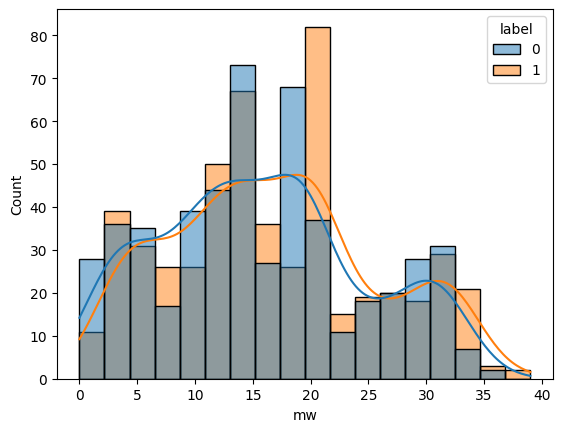

In [4]:
# Check distribution of labels after negative sampling
import seaborn as sns

sns.histplot(apml.df, x='mw', hue='label', kde=True, alpha=0.5)
apml.df.label.value_counts()

In [ ]:
# Build models
apml.build_models(split_strategy='min',
                  task='class',
                  reps=['chemberta-2', 'ecfp', 'esm2-8m'],
                  device='mps', # Change to cuda if using hardware acceleartion
                  models=['svm', 'rf'],
                  n_trials=50)

Partitioning...
Initialising Hestia Dataset Generator
Number of items in data: 1,042
Calculating similarity...
Calculating molecular similarities using mapc with 2,048 bits, radius 4 and jaccard index...


Query FPs:   4%|▎         | 37.0/1.04k [00:06<02:55, 5.72it/s]


<Axes: title={'center': 'Optimization history'}, xlabel='Trial', ylabel='MCC'>

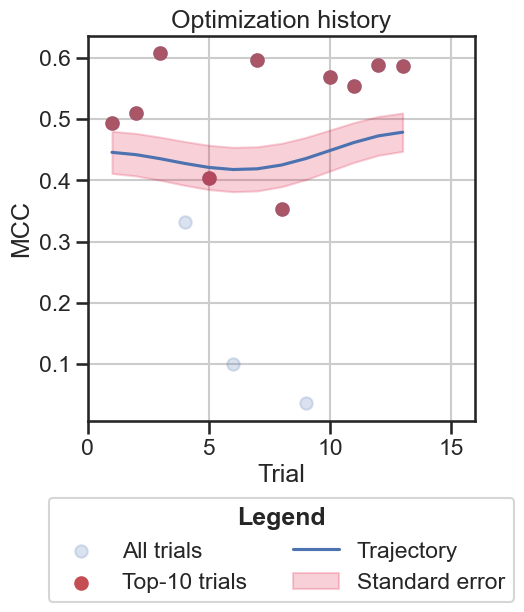

In [ ]:
from autopeptideml.utils.hpo_plots import plot_optimization_history

plot_optimization_history(apml.trainer.history)

<Axes: title={'center': 'Model vs Representation (Annotated with Trial Count)'}, xlabel='Representation', ylabel='Model'>

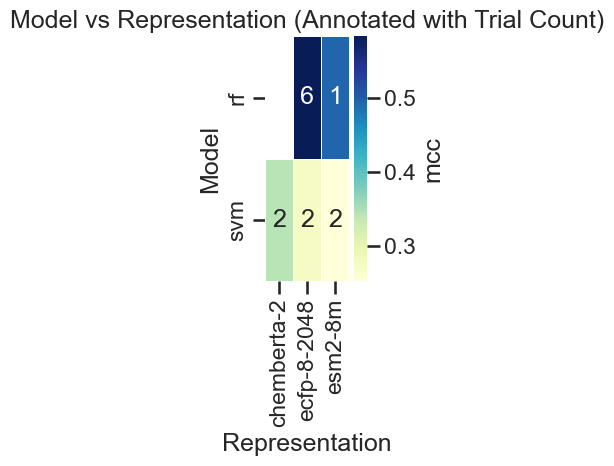

In [ ]:
from autopeptideml.utils.hpo_plots import plot_model_vs_rep

plot_model_vs_rep(apml.trainer.history)

In [ ]:
apml._evaluating()

TypeError: AutoPeptideML._evaluating() missing 1 required positional argument: 'task'

In [ ]:
apml.trainer.history

In [ ]:
from os import path as osp

input_trial = {rep: apml.x[rep][:10] for rep in apml.trainer.best_model.reps}
preds = apml.trainer.best_model.predict(input_trial)

apml.trainer.best_model.save(osp.join(apml.outputdir, 'ensemble'))

In [ ]:
from autopeptideml.train.architectures import VotingEnsemble
ensemble = VotingEnsemble.load(osp.join(apml.outputdir, 'ensemble'))

preds = apml.trainer.best_model.predict(input_trial)[0]
preds2 = ensemble.predict(input_trial)[0]
